## zooC:phytoC

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import pop_tools
from scipy import stats
from cartopy.util import add_cyclic_point
from IPython.display import Image

Cannot write to data cache folder '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.


### Define latest year and get the CESM data

In [2]:
start_yr = 52
num_years = 10
endyr = start_yr + num_years 
case = 'g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.zoo4longlived2'
user = 'kristenk'

In [3]:
files = []
for year in range(start_yr,endyr):
    yr4="{:04d}".format(year)
    print('doing simulation year', year, '!')
    for month in range(1, 13):
    
        mo2="{:02d}".format(month)
        files.extend(sorted(glob(f'/glade/scratch/{user}/archive/{case}/ocn/hist/{case}.pop.h.{yr4}-{mo2}.nc')))
        #files.extend(sorted(glob(f'/glade/scratch/{user}/{case}/run/{case}.pop.h.{yr4}-{mo2}.nc')))

doing simulation year 52 !
doing simulation year 53 !
doing simulation year 54 !
doing simulation year 55 !
doing simulation year 56 !
doing simulation year 57 !
doing simulation year 58 !
doing simulation year 59 !
doing simulation year 60 !
doing simulation year 61 !


In [4]:
cesm_mon_ds=xr.open_mfdataset(files,decode_times=False,decode_coords=False, concat_dim='time')

### Keep only the variables we need

In [5]:
variables = ['photoC_TOT_zint','photoC_sp_zint',
             'photoC_diat_zint','photoC_diaz_zint','photoC_cocco_zint',
             'diatC', 'coccoC','spC','diazC',
            'zoo1C','zoo2C','zoo3C','zoo4C','x_graze_zoo1_zint','x_graze_zoo2_zint',
            'x_graze_zoo3_zint','x_graze_zoo4_zint'] 
coords = {'x':'TLONG','y':'TLAT'}

In [6]:
keepthese=['z_t','z_t_150m','time_bound','TAREA','REGION_MASK'] + variables
keep_vars = keepthese +list(coords.values())+['dz','KMT']
cesm_mon_ds = cesm_mon_ds.drop([v for v in cesm_mon_ds.variables if v not in keep_vars])

In [7]:
ds=cesm_mon_ds.mean(dim='time')

In [8]:
ds_grid = pop_tools.get_grid('POP_gx1v7')

lons=ds_grid.TLONG
lats=ds_grid.TLAT
area=ds_grid.TAREA
depths=ds_grid.z_t * 0.01
area_m=area * 1.e-4
dz_m=ds_grid.dz * 0.01

### depth integrate biomass fields

In [9]:
tmp = ds.zoo1C * 10.
ds['zoo1C_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.zoo2C * 10.
ds['zoo2C_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.zoo3C * 10.
ds['zoo3C_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.zoo4C * 10.
ds['zoo4C_zint'] = tmp.sum(dim='z_t_150m')

ds['zooC_TOT_zint'] = ds['zoo1C_zint'] + ds['zoo2C_zint'] + ds['zoo3C_zint'] + ds['zoo4C_zint']

tmp = ds.spC * 10.
ds['spC_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.diatC * 10.
ds['diatC_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.coccoC * 10.
ds['coccoC_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.diazC * 10.
ds['diazC_zint'] = tmp.sum(dim='z_t_150m')

ds['phytoC_TOT_zint'] = ds['spC_zint'] + ds['diatC_zint'] + ds['coccoC_zint'] + ds['diazC_zint']

In [10]:
ds['zoo_prod_TOT_zint'] = ds['x_graze_zoo1_zint'] + ds['x_graze_zoo2_zint'] + ds['x_graze_zoo3_zint'] + ds['x_graze_zoo4_zint']

### zooC/phytoC ratio

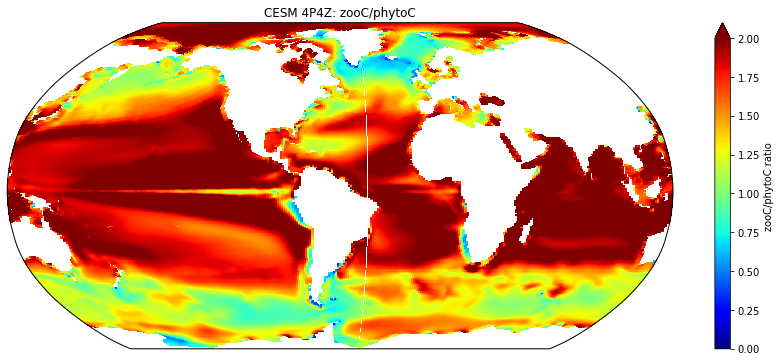

In [11]:
fig = plt.figure(figsize=(15,6))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('CESM 4P4Z: zooC/phytoC', fontsize=12)
pc=ax.pcolormesh(lons, lats, ds.zooC_TOT_zint/ds.phytoC_TOT_zint, cmap='jet',
                 vmin=0,vmax=2,
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='zooC/phytoC ratio')


### production ratio maps

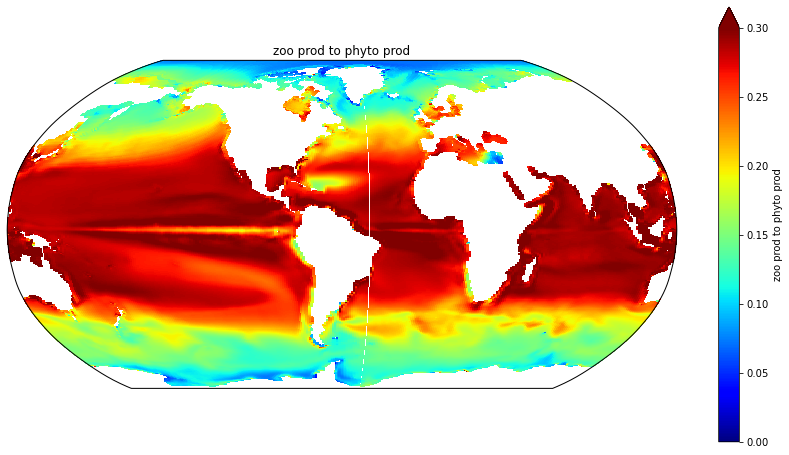

In [12]:
fig = plt.figure(figsize=(15,8))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('zoo prod to phyto prod', fontsize=12)
tmp = ds.zoo_prod_TOT_zint/ds.photoC_TOT_zint
pc=ax.pcolormesh(lons, lats, tmp, cmap='jet',vmin=0,vmax=0.3,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='zoo prod to phyto prod')

### grab CORE-forced cocco run

In [13]:
case = 'cesm22cocco.G1850ECOIAF.T62_g17.003'
path = '/glade/campaign/cgd/oce/projects/besome/cesm-cases/' + case + '/ocn/proc/tseries/month_1'
variables = ['spC','diatC','coccoC','diazC','zooC']

In [14]:
%%time
ds_list = []
print(f'reading {case}')
ds2 = xr.Dataset()

for v in variables:
    
    files = sorted(glob(f'{path}/{case}.pop.h.{v}.024901-031012.nc'))       
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True, chunks={'z_t' : 1})

    ds2 = xr.merge((ds2, dsv))
    ds_list.append(ds2)

reading cesm22cocco.G1850ECOIAF.T62_g17.003
CPU times: user 2.21 s, sys: 139 ms, total: 2.35 s
Wall time: 4.86 s


In [15]:
coords = {'x':'TLONG','y':'TLAT'}
keepthese=['z_t','time_bound','TAREA','REGION_MASK'] + variables
keep_vars = keepthese +list(coords.values())+['dz','KMT']
ds2 = ds2.drop([v for v in ds2.variables if v not in keep_vars])

In [16]:
%%time 
cesm_ann_ds=ds2.mean(dim='time').compute()

CPU times: user 3min 25s, sys: 5min 18s, total: 8min 44s
Wall time: 10min 2s


In [17]:
cesm_ann_ds['zooC_zint'] = (cesm_ann_ds.zooC * 10.).sum(dim='z_t_150m')

diatC_zint = (cesm_ann_ds.diatC * 10.).sum(dim='z_t_150m')
spC_zint = (cesm_ann_ds.spC * 10.).sum(dim='z_t_150m')
coccoC_zint = (cesm_ann_ds.coccoC * 10.).sum(dim='z_t_150m')
diazC_zint = (cesm_ann_ds.diazC * 10.).sum(dim='z_t_150m')

cesm_ann_ds['spC_zint'] = spC_zint
cesm_ann_ds['diatC_zint'] = diatC_zint
cesm_ann_ds['coccoC_zint'] = coccoC_zint
cesm_ann_ds['tot_phytoC_zint'] = diatC_zint + spC_zint + coccoC_zint + diazC_zint


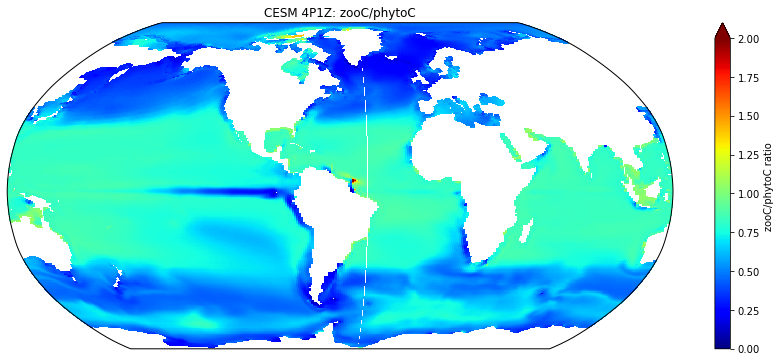

In [18]:
fig = plt.figure(figsize=(15,6))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('CESM 4P1Z: zooC/phytoC', fontsize=12)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds.zooC_zint/cesm_ann_ds.tot_phytoC_zint, cmap='jet',
                 vmin=0,vmax=2,
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='zooC/phytoC ratio')
